In [1]:
import numpy as np
import pandas as pd
import os
import itertools
import glob
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.metrics import f1_score
from sklearn import metrics

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

In [3]:
from PreprocessingLabeledData import *
from AddingPredProbAndLabel2DF import *
from OverLapReturner import OverLapReturner
from SelectingBestNonOverlappingHits import *

In [4]:
%matplotlib inline

In [5]:
LabeledDataAddressDict = {}
LabeledDataAdds = sorted(glob.glob("../intermediates/*/*_labeled.tsv"))
DictOfAdds = {os.path.normpath(x).split(os.sep)[2]:x for x in LabeledDataAdds}
FullNameDict = {"Sc": "S. cerevisiae", "Ec":"E. coli","Mj":"M. jannaschii", "Tb":"T. brucei"}

In [7]:
AddressTbData = DictOfAdds["Tb"]
TbData = pd.read_csv(AddressTbData, sep="\t")
TbData = PreprocessingLabeledData(TbData)
LabeledData_tb = TbData[TbData["Status"]!=-1]
LabeledData_tb = LabeledData_tb.sample(frac=1, random_state=1).reset_index(drop=True)

X_tb = LabeledData_tb.values # The alignments of Tb will have a distinct naming convention
y_tb = LabeledData_tb['Status'].values # The alignments of Tb will have a distinct naming convention

In [8]:
totalNumAli = TbData.shape[0]
print("There are a total of {} possible alignments between Proteome of interest and Pfam instances".format(totalNumAli))
print("{} percent of the data is labeled as 1 ".format(LabeledData_tb[LabeledData_tb["Status"]==1].shape[0]*100/totalNumAli))
print("{} percent of the data is labeled as 0 ".format(LabeledData_tb[LabeledData_tb["Status"]==0].shape[0]*100/totalNumAli))

There are a total of 1529462 possible alignments between Proteome of interest and Pfam instances
31.28054178528136 percent of the data is labeled as 1 
40.005570586258436 percent of the data is labeled as 0 


In [9]:
TbData.columns

Index(['fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'qlen', 'bits',
       'alntmscore', 'FracOfPf', 'p_evalue', 'query', 'target', 'qstart',
       'qend', 'tstart', 'tend', 'tlen', 'PredPF', 'PF', 'PFstart', 'PFend',
       'evalue', 'Status'],
      dtype='object')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_tb, y_tb, train_size = 0.9, test_size=0.1, shuffle=False)
X_cv, X_test, y_cv, y_test = train_test_split(X_test, y_test, train_size = 0.5, test_size=0.5, shuffle=False)

In [11]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
rf.fit(X_train[:,:8], y_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [ ]:
#import joblib
#joblib.dump(rf, "./PFAS_RF.joblib", compress=3)

In [12]:
ModelDict = {}
TrainSizes = [0.01] #Add whatever fraction you want to test to this dictionary
ModelDict[1] = rf
for train_size in TrainSizes:
    X_train_frac, X_test_frac, y_train_frac, y_test_frac = train_test_split(X_train,y_train, train_size = train_size, test_size=1- train_size, shuffle=False)
    rf = RandomForestClassifier(n_estimators=100, criterion='gini', n_jobs=-1)
    rf.fit(X_train_frac[:,:8], y_train_frac)
    ModelDict[train_size] = rf


In [13]:
X_dict_orgs = {}
y_dict_orgs = {}

for org in DictOfAdds:
    if org == "Tb":
        continue 
    Data = pd.read_csv(DictOfAdds[org], sep="\t")
    Data = PreprocessingLabeledData(Data)
    print("The summary of the alignments for {}".format(org))
    print("There are total of {} possible alignments between Proteome of {} and Pfam instances".format(Data.shape[0], org))
    totalNum = Data.shape[0]
    print("{} percent of the data is labeled 1 ".format(Data[Data["Status"]==1].shape[0]/totalNum*100))
    print("{} percent of the data is labeled 0 ".format(Data[Data["Status"]==0].shape[0]/totalNum*100))
    Data = Data[Data["Status"]!=-1]
    X_dict_orgs[org] = Data.values
    y_dict_orgs[org] = Data['Status'].values

The summary of the alignments for Ec
There are total of 1877593 possible alignments between Proteome of Ec and Pfam instances
38.674675502092306 percent of the data is labeled 1 
58.71602631667246 percent of the data is labeled 0 
The summary of the alignments for Mj
There are total of 738979 possible alignments between Proteome of Mj and Pfam instances
29.996928194170607 percent of the data is labeled 1 
62.78554600333703 percent of the data is labeled 0 
The summary of the alignments for Sc
There are total of 1604933 possible alignments between Proteome of Sc and Pfam instances
35.98829359231818 percent of the data is labeled 1 
48.531496330376406 percent of the data is labeled 0 


<Figure size 640x480 with 0 Axes>

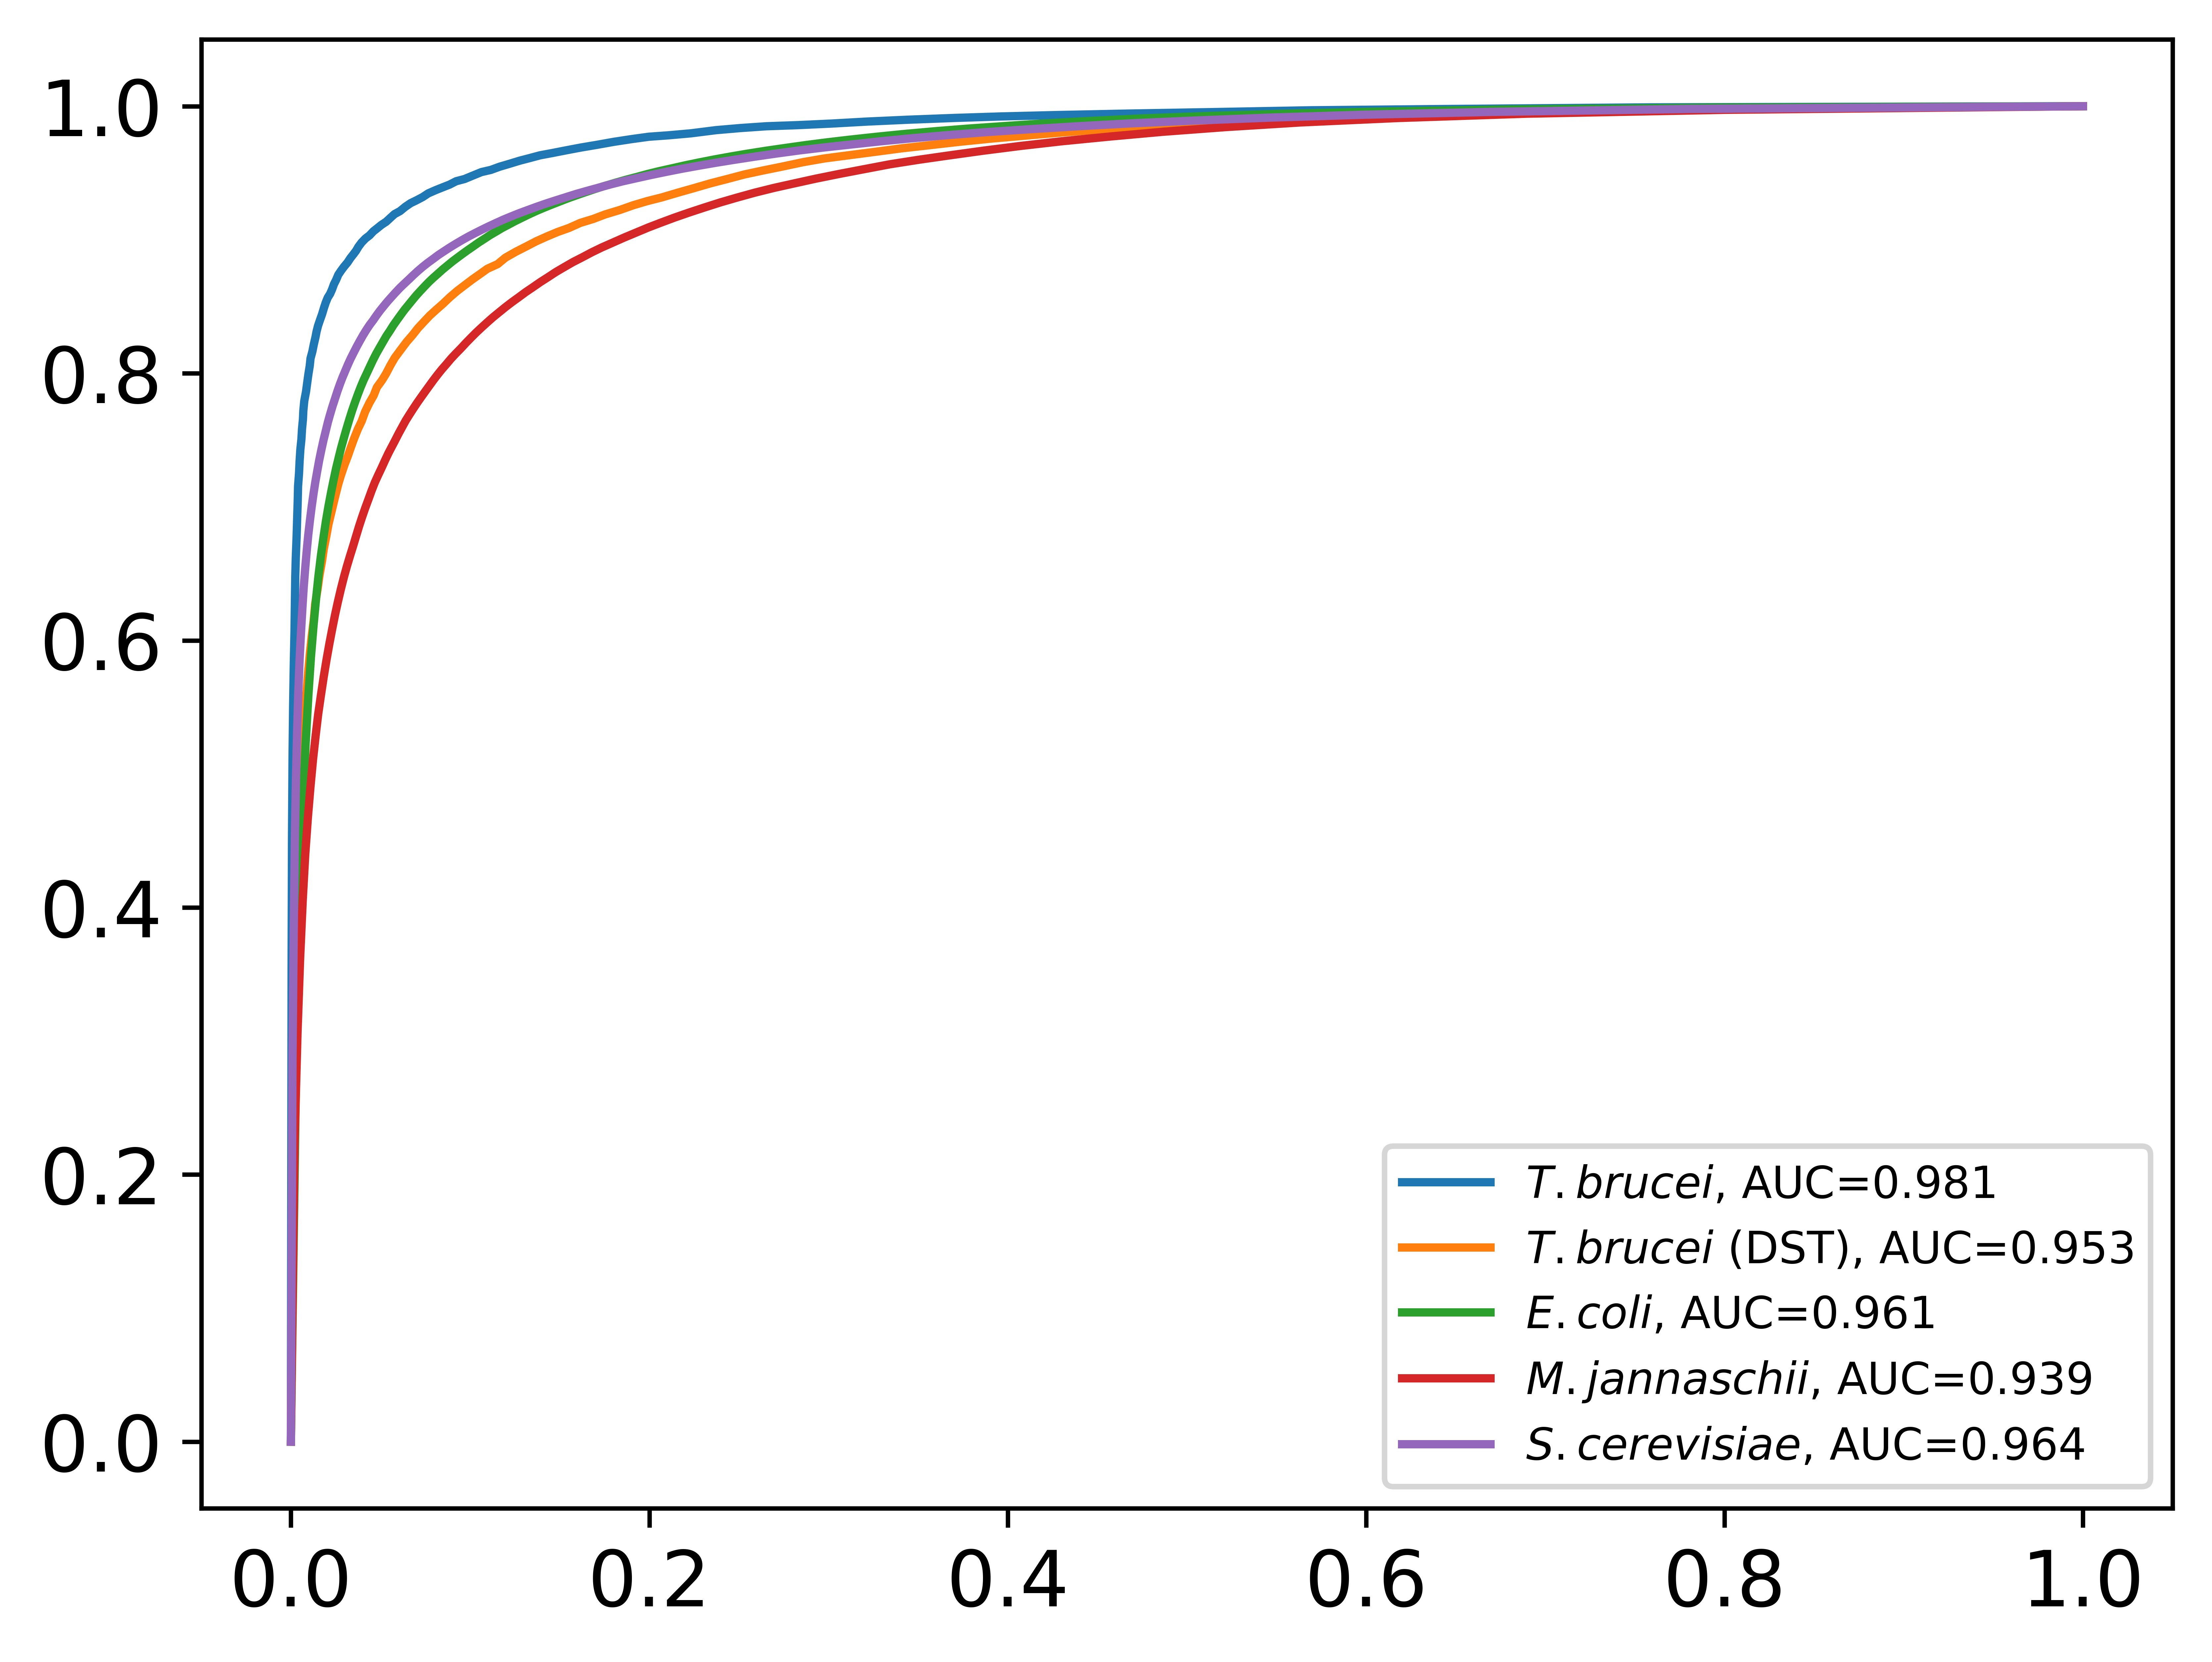

In [14]:
plt.figure(0).clf()
plt.figure(dpi=1200)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#add legend
#plt.legend()
ProbDict = {}

for frac in ModelDict.keys():
    model = ModelDict[frac]
    y_pred_prob = model.predict_proba(X_test[:,:8])[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
    auc = round(metrics.roc_auc_score(y_test, y_pred_prob),3)
    if frac!= 1:
        plt.plot(fpr,tpr,label= "$\it{T. brucei}$ (DST)" +", AUC="+str(auc))
    else:
        plt.plot(fpr,tpr,label= "$\it{T. brucei}$" + ", AUC="+str(auc))
        ProbDict["Tb"] = y_pred_prob
   
model = ModelDict[1]
for org in X_dict_orgs.keys():
    y_pred_prob = model.predict_proba(X_dict_orgs[org][:,:8])[:, 1]
   
    fpr, tpr, _ = metrics.roc_curve(y_dict_orgs[org], y_pred_prob)
    auc = round(metrics.roc_auc_score(y_dict_orgs[org], y_pred_prob),3)
    plt.plot(fpr,tpr,label= "$\it{" + FullNameDict[org] + "}$" + ", AUC="+str(auc))
    ProbDict[org] = y_pred_prob

plt.legend( prop={'size': 8})

The following cell calculates the accuracy of the classifier on all alignments of each organism

In [66]:
#PfamClan = pd.read_csv("../rawinput/PfamClanAssociation.tsv", sep="\t", header=None)
#PfamClan.columns = ["PF", "Clan"]

In [85]:
DF_dict = {}
for org in ProbDict.keys():
    PredProbs = ProbDict[org]
    Preds = (PredProbs>=0.5).astype(int) #
    if org == "Tb":
        X_of_org = X_test
        ACC = (Preds==X_test[:,-1]).sum()/Preds.shape[0]
    else:
        X_of_org = X_dict_orgs[org]
    Labels = X_of_org[:,-1] #
    PredPF = X_of_org[:, 16] #
    PF = X_of_org[:, 17] #
    
    orgDF = pd.DataFrame({"PredLabel":Preds, "Label": Labels,"PredPF":PredPF, "PF":PF })
    #ClanOfS = orgDF[["PredPF"]].merge(PfamClan, left_on="PredPF", right_on="PF")["Clan"]
    #ClanOfQ = orgDF[["PF"]].merge(PfamClan, left_on="PF", right_on="PF")["Clan"]
    #print(ClanOfS.shape)
    #print(ClanOfQ.shape)
    #orgDF["ClanLabel"] = orgDF["Label"]
    #ser = ((orgDF["PredLabel"]==1) & (ClanOfS==ClanOfQ))&(orgDF["Label"]==0)
    #print(ser.sum())
    #nums = ((orgDF["PredLabel"]==1) & (ClanOfS==ClanOfQ))&(orgDF["Label"]==0)
    #print(orgDF[nums])
    #orgDF.loc[nums,"ClanLabel"]= 1
    #print(orgDF[nums])

    DF_dict[org] = orgDF
    
    print("Accuracy for {} in Pfam Level is {}".format( org, (Preds==orgDF["Label"]).sum()/Labels.shape[0]))
    #print("Accuracy for {} in Clan Level is {}".format( org, (Preds==orgDF["ClanLabel"]).sum()/Labels.shape[0]))

Accuracy for Tb in Pfam Level is 0.9330459506557828
Accuracy for Tb in Clan Level is 0.9353755847014583
Accuracy for Ec in Pfam Level is 0.8983474251627337
Accuracy for Ec in Clan Level is 0.9006623096017119
Accuracy for Mj in Pfam Level is 0.8771868158794008
Accuracy for Mj in Clan Level is 0.8828501129596598
Accuracy for Sc in Pfam Level is 0.9065600382163914
Accuracy for Sc in Clan Level is 0.9093002065631345


In [97]:
from scipy.stats import binom
def CalcAccuracyAndPval(df, ACC):
    CorrectNums = (df["PredLabel"]==df["Label"]).sum()
    SampleSize = df.shape[0]
    #print(SampleSize)
    accuracy = CorrectNums/SampleSize
    #accuracy_clan = (df["PredLabel"]==df["ClanLabel"]).sum()/SampleSize
    p_value = binom.cdf(CorrectNums,SampleSize,ACC)
    df["accuracy"] = accuracy
    #df["accuracy_clan"] = accuracy_clan
    df["p_value"] = p_value
    return df

In [117]:
Ans = DF_dict["Tb"].groupby("PredPF").apply(lambda x: CalcAccuracyAndPval(x, ACC))

In [118]:
PfamStatified = Ans.drop_duplicates(["PF"])[["PF", "accuracy", "p_value"]]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

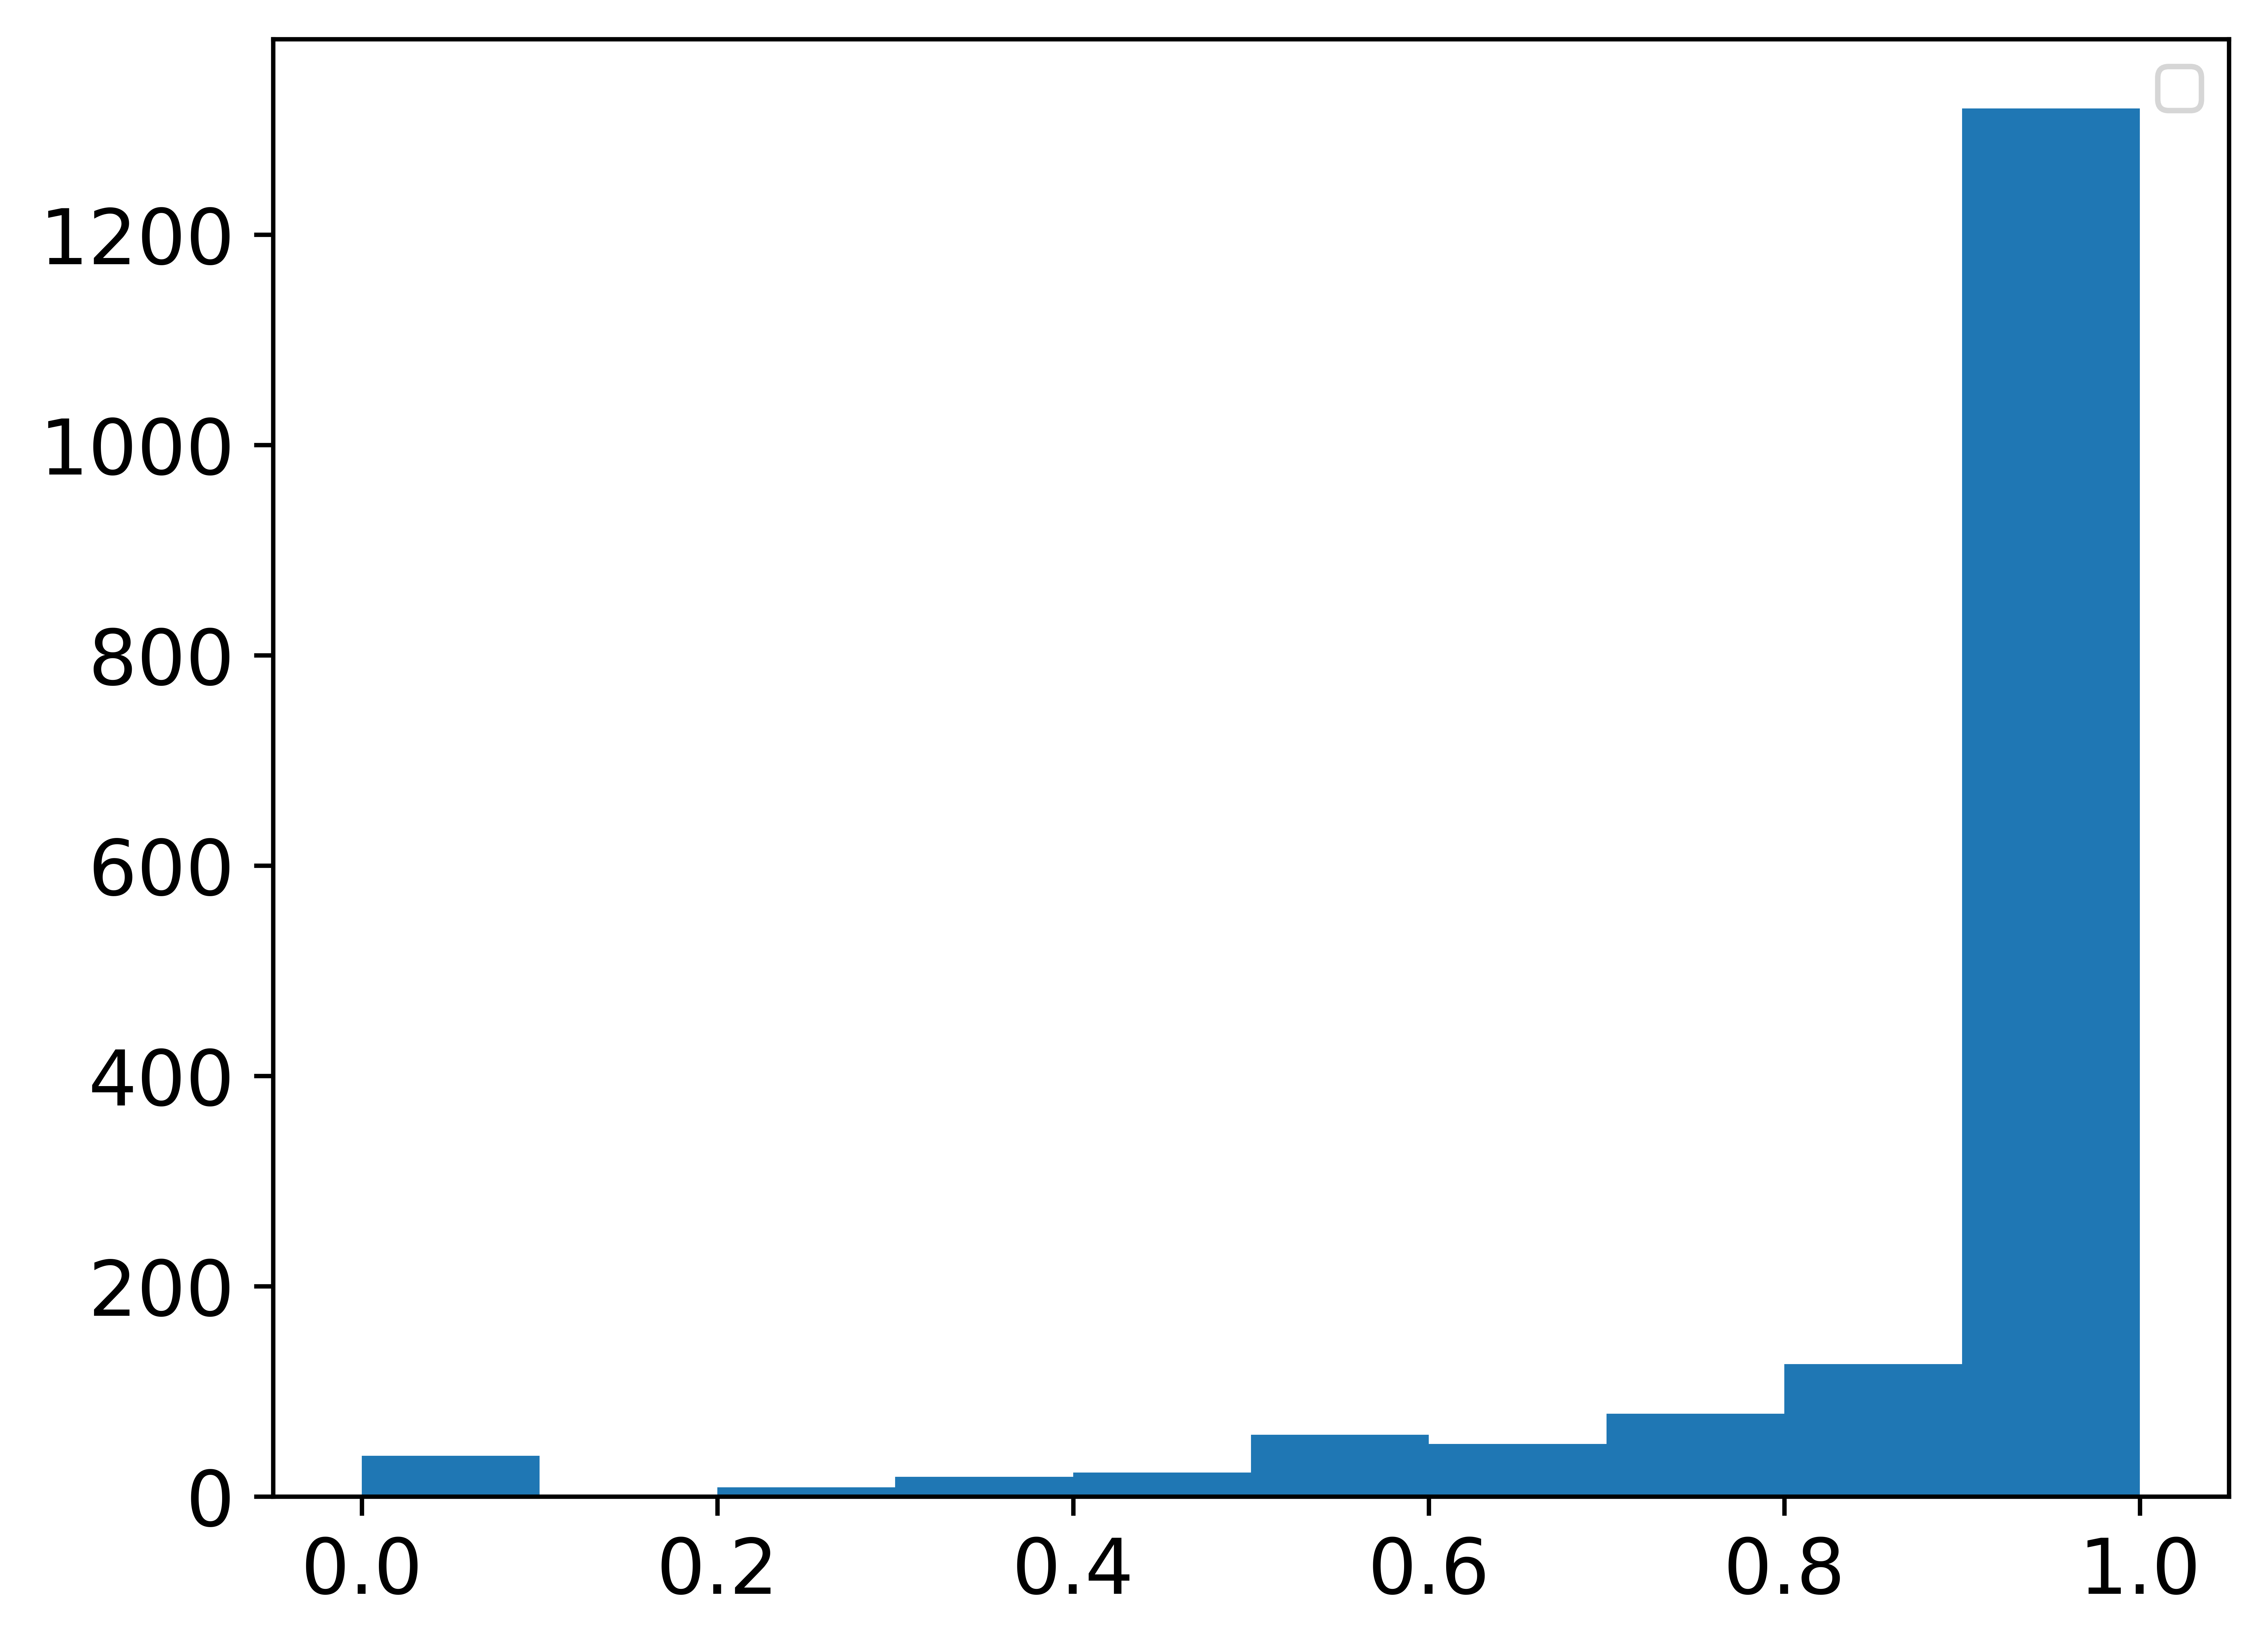

In [120]:
#PfamStatified["LogP"] = -np.log(PfamStatified["p_value"])

plt.figure(0).clf()
plt.figure(dpi=1200)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.hist(PfamStatified["accuracy"])
plt.legend()

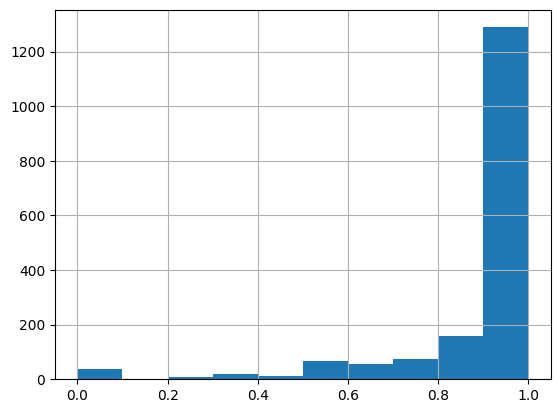

In [105]:
#PfamStatifiedPvalLessThan1Percent = PfamStatified[(PfamStatified["p_value"]< 0.01)]
#PfamStatifiedPvalLessThan1Percent["accuracy"].hist()
#PfamStatified["accuracy_clan"].hist()
#PfamStatifiedPvalLessThan1Percent.sort_values(by="accuracy_clan",ascending=True).to_csv("../ShortComings2.tsv", sep="\t", index=None)
#print(PfamStatified["accuracy"].sum()/PfamStatified.shape[0])

<AxesSubplot:>

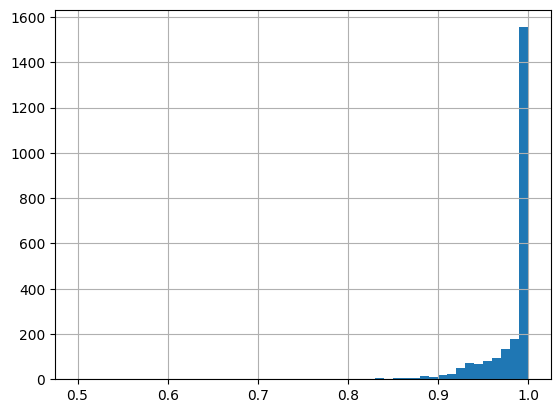

In [135]:
AnsSc = DF_dict["Sc"].groupby("PF").(lambda x: CalcAccuracyAndPval(x, ACC))
PfamStatifiedSc = AnsSc.drop_duplicates(["PF"])[["PF", "accuracy", "p_value"]]
#PfamStatifiedPvalLessThan1Percent[PfamStatifiedPvalLessThan1Percent["accuracy"]< 0.1]
PfamStatifiedPvalLessThan1PercentSc = PfamStatifiedSc[PfamStatifiedSc["p_value"]> 0.1]
PfamStatifiedPvalLessThan1PercentSc["accuracy"].hist(bins=50)

In [134]:
print(PfamStatifiedPvalLessThan1PercentSc.shape)
print(PfamStatifiedSc.shape)

(2330, 3)
(3118, 3)


<AxesSubplot:>

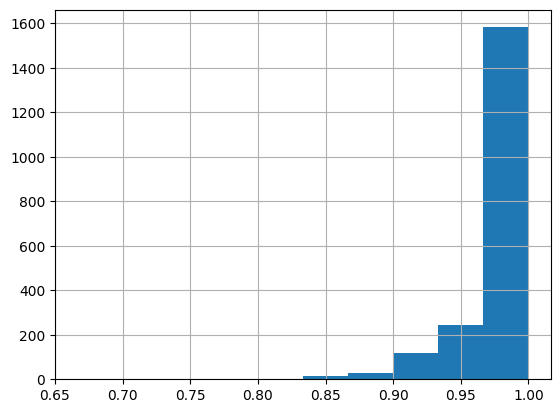

In [132]:
AnsEc = DF_dict["Ec"].groupby("PF").apply(lambda x: CalcAccuracyAndPval(x, ACC))
PfamStatifiedEc = AnsEc.drop_duplicates(["PF"])[["PF", "accuracy", "p_value"]]
#PfamStatifiedPvalLessThan1Percent[PfamStatifiedPvalLessThan1Percent["accuracy"]< 0.1]
PfamStatifiedPvalLessThan1PercentEc = PfamStatifiedEc[PfamStatifiedEc["p_value"]> 0.1]
PfamStatifiedPvalLessThan1PercentEc["accuracy"].hist()

<AxesSubplot:>

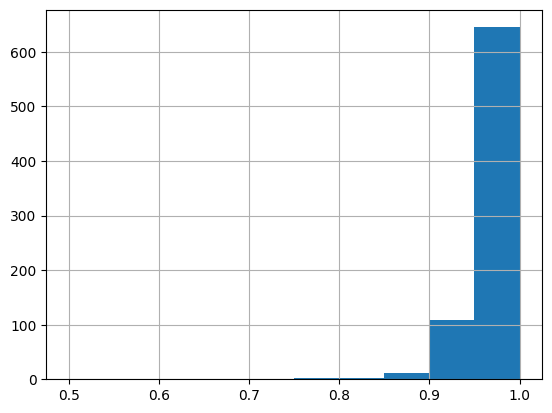

In [133]:
AnsMj = DF_dict["Mj"].groupby("PF").apply(lambda x: CalcAccuracyAndPval(x, ACC))
PfamStatifiedMj = AnsMj.drop_duplicates(["PF"])[["PF", "accuracy", "p_value"]]
PfamStatifiedPvalLessThan1PercentMj = PfamStatifiedMj[PfamStatifiedMj["p_value"]> 0.1]
PfamStatifiedPvalLessThan1PercentMj["accuracy"].hist()

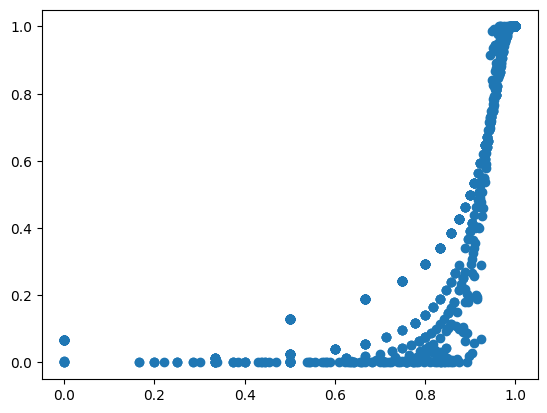

In [110]:
plt.scatter(PfamStatified["accuracy"], PfamStatified["p_value"])

(49068,)

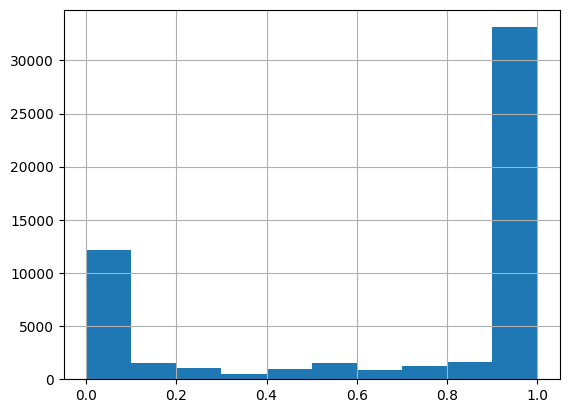

In [105]:
Ans["p_value"].hist()
Ans[Ans["p_value"]> 0.0001]["p_value"].shape

In [68]:
DF_dict["Tb"].groupby("PF").get_group("PF00004")

,PredLabel,Label,PredPF,PF
1,0,0,PF05673,PF00004
3,0,0,PF13177,PF00004
33,0,0,PF05729,PF00004
60,0,0,PF13191,PF00004
63,1,1,PF00004,PF00004
...,...,...,...,...
54387,0,0,PF07724,PF00004
54412,1,1,PF00004,PF00004
54447,0,0,PF13191,PF00004
54456,0,0,PF13173,PF00004


In [53]:
X_test.shape
DatY = ProbDict["Tb"]
Preds = (DatY>=0.5).astype(int)


In [211]:
model = ModelDict[1]
y_pred_prob = model.predict_proba(X_test[:,:8])[:, 1]

In [213]:
X_test_org = X_dict_orgs["Sc"]
y_pred_prob = model.predict_proba(X_dict_orgs["Sc"][:,:8])[:, 1]
TestDF = pd.DataFrame({"Pfam": X_test_org[:,17], "Status":X_test_org[:,21], "Prob": y_pred_prob})

In [148]:
CountDFs = TestDF.groupby('Pfam')['Pfam'].count()

# Best hit attribution benchmarking
The next part is for Evaluating Best Hit attribution, first, we have to predict the probability and the label of each alignment by the trained model, then select the best hit, and continue annotating new domain to the point each newly added domain overlaps less than 10 aminoacids with previously added domains.

In [14]:
def Precision(df):
    TotalPreds = df.shape[0]
    CorrectPreds = df[df["Status"]==1].shape[0]
    return CorrectPreds/TotalPreds

In [18]:
model = ModelDict[1]
PrecisionDict = {}
AnnotDict = {}
AnnotDFTb = SelectingBestNonOverlappingHits(AddingPredProbAndLabel2DF(X_tb, model))
AnnotDict["Tb"] = AnnotDFTb

for org in X_dict_orgs.keys():
    AnnotDF = SelectingBestNonOverlappingHits(AddingPredProbAndLabel2DF(X_dict_orgs[org], model))
    AnnotDict[org] = AnnotDF

In [64]:
AnnotDict.keys()

dict_keys(['Tb', 'Ec', 'Mj', 'Sc'])

In [19]:
for org in AnnotDict.keys():
    annots = AnnotDict[org]
    TruePreds = annots[annots["Status"]==1] 
    print("{} percent of Annotated Pfams have been correctly annotated for {}".format(100* Precision(annots), org))
    

99.21832394110162 percent of Annotated Pfams have been correctly annotated for Tb
97.69896193771626 percent of Annotated Pfams have been correctly annotated for Ec
95.28985507246377 percent of Annotated Pfams have been correctly annotated for Mj
98.13084112149532 percent of Annotated Pfams have been correctly annotated for Sc


In [20]:
model = ModelDict[1]
FeatureImps = model.feature_importances_
FeatureNames = ['fident', 'alnlen', 'nmismatch', 'ngapopen', 'pflen', 'bit score', 'TM-score', "pfcov"]
SortedFeatures = sorted(zip(FeatureNames, FeatureImps), key=lambda x: x[1], reverse=True)
for item in SortedFeatures:
    print(item[0] + "\t"+ str(item[1]))

fident	0.19322817854303703
ngapopen	0.18906449625577385
bit score	0.15793740717220506
TM-score	0.13428641462751315
pflen	0.10768882248839466
alnlen	0.09253148478940988
pfcov	0.06728671779507853
nmismatch	0.05797647832858782


# Annotating New Genes in T. brucei

In [24]:
PfamAnnDict = {}
PfamsTb = open("../rawinput/Tb/PfamTb.txt")
for line in PfamsTb:
    Gene, Pf, start,end = line.strip().split()
    Intervals = PfamAnnDict.get(Gene, [])
    Intervals.append((int(start), int(end)))
    PfamAnnDict[Gene] = Intervals

In [25]:
X_to_check_Tb = TbData[TbData["Status"]==-1].values

In [28]:
model = ModelDict[1]
NewlyAnn = SelectingBestNonOverlappingHits(AddingPredProbAndLabel2DF(X_to_check_Tb, model), PfamAnnDict)

In [29]:
NewlyAnn.columns
NewlyAnn = NewlyAnn[['target', 'PredPF', 'tstart', 'tend', 'RF_prob','query', 'fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'qlen', 'bits',
       'alntmscore', 'FracOfPf', 'p_evalue',  'qstart',
       'qend', 'tlen', 'PF', 'PFstart', 'PFend',
       'evalue', 'Status', 'PredLabel']]
NewlyAnn = NewlyAnn[['target', 'PredPF', 'tstart', 'tend', 'RF_prob','query', 'fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'qlen', 'bits',
       'alntmscore', 'FracOfPf', 'p_evalue',  'qstart',
       'qend', 'tlen']]

In [30]:
NewlyAnn.columns = ['Query', 'PredPF', 'Qstart', 'Qend', 'RF_prob','PFinstance', 'fident', 'alnlen', 'nmismatch', 'ngapopen', 'PFlen', 'bit score',
       'alntmscore', 'pfcov', 'p_evalue',  'InstanceStart',
       'InstanceEnd', 'Qlen']

In [31]:
NewlyAnn.to_csv("../predictions/NewPredictionsTb.txt", index=None, sep="\t")

In [32]:
NewlyAnn.groupby(['PredPF'])['PredPF'].count().sort_values(ascending=False)[:10]

PredPF
PF13458    72
PF12799    50
PF00400    41
PF00913    31
PF00560    30
PF00076    29
PF12894    20
PF01762    19
PF14783    19
PF00225    16
Name: PredPF, dtype: int64